In [1]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import bm3d_streak_removal as bm3d

olefile module not found


In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
ncore = 48
if ncore > mp.cpu_count():
    ncore = mp.cpu_count()
ncore

48

# Workflow starts here!

In [5]:
###################### need to change start
ipts="29298"
###################### need to change end

## Find CT scan location

In [6]:
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ct_loc)

['2022_09_29_sample2',
 '2022_09_29_sample1',
 '2022_09_29_sample4',
 '2022_09_29_sample3']

## Find OB location

In [7]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ob_loc)

['2022_09_29', '2022_09_30']

## Find DC location

In [8]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(dc_loc)

['2022_09_29']

In [9]:
###################### need to change start
sample_name = "2022_09_29_sample4"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2022_09_30")
dc_dir = os.path.join(dc_loc, "2022_09_29")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
end_ang = 359.1 # Will not be used if the CT file names contain angle info
ct_name = "*battery*" # Will not be used if follows the default file structure
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
output_hdf5 = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/" + sample_name + ".h5"
###################### need to change end

# Load all data files (CT, OB and DC)

In [10]:
######### CT
proj_raw, ang_deg, ang_rad, proj180_idx, proj000_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Found index of 180 degree projections: 391 of angle 179.86
Found index of 0 degree projections: 0 of angle 0.0
Loading 783 CT projections...


783it [00:24, 31.34it/s]


783 CT projections loaded!
Shape: (783, 2048, 2048)
Loading 5 Open Beam (OB) images...


5it [00:00, 14.13it/s]


5 Open Beam (OB) images loaded!
Shape: (5, 2048, 2048)
Loading 5 Dark Current (DC) images...


5it [00:00, 55.83it/s]

5 Dark Current (DC) images loaded!
Shape: (5, 2048, 2048)


# Visual verification of loaded files

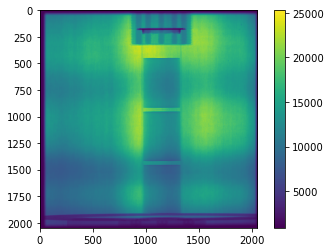

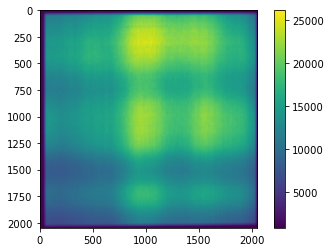

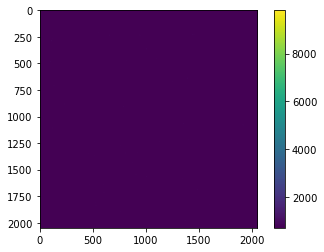

In [11]:
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(proj_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Define/crop ROI

Recon ROI:


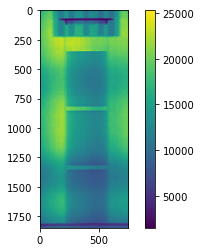

In [14]:
###################### need to change start
crop = True
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 750
crop_right = 1500
crop_top = 100
crop_bottom = 1950
###################### need to change end
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()

# Remove Outliers

In [15]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Time: 11.72041886812076 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalizing...
Normalization Done!
float32
(783, 1850, 750)


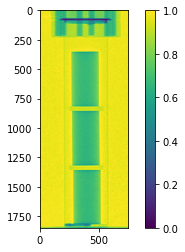

In [16]:
proj_norm, ob_med, dc_med = rocku.normalize(proj_crop, ob_crop, dc_crop)
print(proj_norm.dtype)
print(proj_norm.shape)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Beam fluctuation correction (optional)

Beam fluctuation ROI:


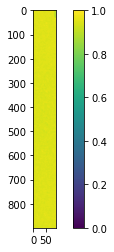

In [17]:
###################### need to change start
bg_left = 5
bg_right = 100
bg_top = 200
bg_bottom = 1100
###################### need to change end
bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

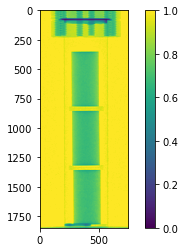

Time: 8.328269600868225 s


In [18]:
t0 = timeit.default_timer()
proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

# Minus log conversion

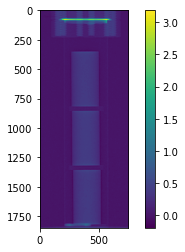

In [21]:
proj_mlog = tomopy.minus_log(proj_norm, ncore=ncore)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

# Ring Artifact Removal

Before ring removal:


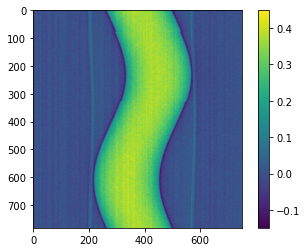

In [25]:
slice_num = 600
print("Before ring removal:")
plt.imshow(proj_mlog[:, slice_num, :])
plt.colorbar()
plt.show()

## (a) Vo's approach from tomopy

In [26]:
nchunk = int(proj_mlog.shape[0]/ncore) + 1
print("Chunk size: ", nchunk)
t0 = timeit.default_timer()
proj_rmv = tomopy.remove_all_stripe(proj_mlog, ncore=ncore, nchunk=nchunk)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))

Chunk size:  17
Time cost 1.1558884679495047 min


Before ring removal:


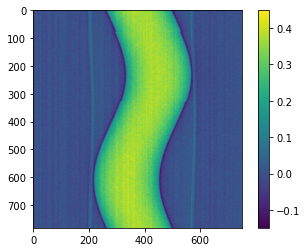

After ring removal:


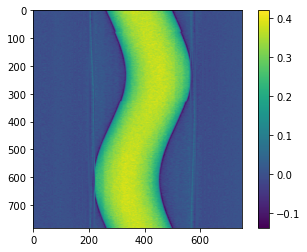

Difference:


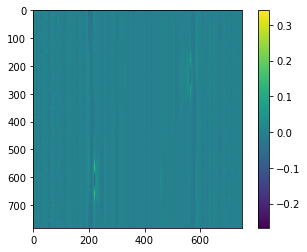

In [27]:
slice_num = 600
print("Before ring removal:")
plt.imshow(proj_mlog[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_rmv[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_rmv[:, slice_num, :]-proj_mlog[:, slice_num, :])
plt.colorbar()
plt.show()

## (b) bm3d approach

In [29]:
# proj_rmv = rocku.remove_ring(proj_norm, algorithm="Vo")
############## bm3d, slightly better, but slow
t0 = timeit.default_timer()
print("Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.")
proj_mlog = bm3d.extreme_streak_attenuation(proj_mlog)
print("Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.")
proj_rmv = bm3d.multiscale_streak_removal(proj_mlog)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))

Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.
Denoising sinogram 0
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 2
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 4
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 6
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 9
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 10
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 11
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 12
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 13
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 14
k: 4
k: 3


k: 3
k: 2
k: 1
k: 0
Denoising sinogram 167
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 168
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 169
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 170
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 171
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 172
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 173
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 174
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 175
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 176
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 177
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 178
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 179
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 180
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 181
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 182
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 183
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 184
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 185
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 186
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 338
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 339
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 340
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 341
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 342
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 343
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 344
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 345
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 346
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 347
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 348
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 349
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 350
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 351
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 352
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 353
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 354
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 355
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 356
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 357
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 509
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 510
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 511
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 512
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 513
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 514
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 515
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 516
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 517
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 518
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 519
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 520
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 521
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 522
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 523
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 524
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 525
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 526
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 527
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 528
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 680
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 681
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 682
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 683
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 684
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 685
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 686
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 687
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 688
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 689
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 690
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 691
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 692
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 693
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 694
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 695
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 696
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 697
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 698
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 699
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 851
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 852
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 853
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 854
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 855
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 856
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 857
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 858
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 859
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 860
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 861
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 862
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 863
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 864
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 865
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 866
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 867
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 868
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 869
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 870
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8

k: 0
Denoising sinogram 1021
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1022
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1023
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1024
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1025
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1026
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1027
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1028
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1029
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1030
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1031
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1032
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1033
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1034
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1035
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1036
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1037
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1038
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1039
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1040
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinog

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1189
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1190
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1191
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1192
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1193
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1194
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1195
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1196
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1197
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1198
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1199
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1200
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1201
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1202
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1203
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1204
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1205
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1206
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1207
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1208
k: 4
k: 3
k: 2
k: 1
k: 0


k: 1
k: 0
Denoising sinogram 1356
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1357
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1358
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1359
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1360
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1361
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1362
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1363
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1364
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1365
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1366
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1367
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1368
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1369
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1370
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1371
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1372
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1373
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1374
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1375
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising 

Denoising sinogram 1523
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1524
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1525
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1526
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1527
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1528
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1529
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1530
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1531
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1532
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1533
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1534
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1535
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1536
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1537
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1538
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1539
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1540
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1541
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1542
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1691
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1692
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1693
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1694
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1695
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1696
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1697
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1698
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1699
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1700
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1701
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1702
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1703
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1704
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1705
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1706
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1707
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1708
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1709
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1710
k: 4
k: 3
k: 2
k: 1
k: 0


Before ring removal:


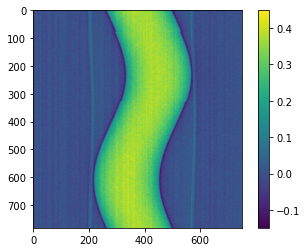

After ring removal:


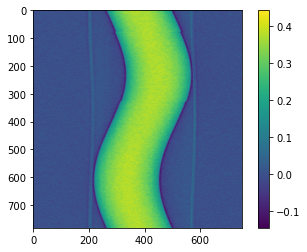

Difference:


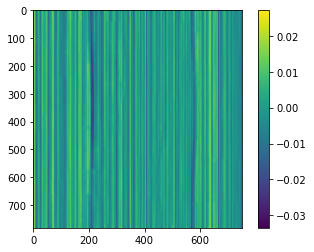

In [30]:
slice_num = 600
print("Before ring removal:")
plt.imshow(proj_mlog[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_rmv[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_rmv[:, slice_num, :]-proj_mlog[:, slice_num, :])
plt.colorbar()
plt.show()

# Export to HDF5

In [47]:
with h5f.File(output_hdf5, mode='a') as f:
#     f.create_group('tomo/raw')
#     f.create_dataset('tomo/raw/proj', data=proj_crop)
#     f.create_dataset('tomo/raw/ob', data=ob_med)
#     f.create_dataset('tomo/raw/dc', data=dc_med)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm', data=proj_norm)
#     f.create_dataset('tomo/proj/proj_mlog', data=proj_mlog)
    f.create_dataset('tomo/proj/proj_rmv', data=proj_rmv, dtype=np.float32)
    f.create_dataset('tomo/proj/ob_fake', data=np.ones((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_dataset('tomo/proj/dc_fake', data=np.zeros((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_group('tomo/sino')
    f.create_dataset('tomo/sino/sino_norm', data=np.moveaxis(proj_norm, 1, 0))
    f.create_dataset('tomo/sino/sino_rmv', data=np.moveaxis(proj_rmv, 1, 0), dtype=np.float32)
    f.create_group('tomo/meta')
    f.create_dataset('tomo/meta/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/meta/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/meta/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/meta/ring_rmv', data=('bm3d',))
    f.create_dataset('tomo/meta/minus_log', data=(True,))
    f.create_dataset('tomo/meta/fluctuation_corr', data=(True,))
    f.create_dataset('tomo/meta/fname', data=fname_sorted)
#     f.create_dataset('tomo/meta/index', data=idx_list, dtype=np.uint16)

In [48]:
losa.get_hdf_tree(output_hdf5)

 tomo
    │
    ├── meta
    │   │
    │   ├── ang_deg (783,)
    │   ├── ang_rad (783,)
    │   ├── fluctuation_corr (1,)
    │   ├── fname (783,)
    │   ├── minus_log (1,)
    │   ├── proj180_idx (1,)
    │   └── ring_rmv (1,)
    ├── proj
    │   │
    │   ├── dc_fake (1850, 750)
    │   ├── ob_fake (1850, 750)
    │   ├── proj_norm (783, 1850, 750)
    │   └── proj_rmv (783, 1850, 750)
    └── sino
        │
        ├── sino_norm (1850, 783, 750)
        └── sino_rmv (1850, 783, 750)


deque([' tomo',
       '    │',
       '    ├── meta',
       '    │   │',
       '    │   ├── ang_deg (783,)',
       '    │   ├── ang_rad (783,)',
       '    │   ├── fluctuation_corr (1,)',
       '    │   ├── fname (783,)',
       '    │   ├── minus_log (1,)',
       '    │   ├── proj180_idx (1,)',
       '    │   └── ring_rmv (1,)',
       '    ├── proj',
       '    │   │',
       '    │   ├── dc_fake (1850, 750)',
       '    │   ├── ob_fake (1850, 750)',
       '    │   ├── proj_norm (783, 1850, 750)',
       '    │   └── proj_rmv (783, 1850, 750)',
       '    └── sino',
       '        │',
       '        ├── sino_norm (1850, 783, 750)',
       '        └── sino_rmv (1850, 783, 750)'])

# Remove Outliers again (optional)

In [ ]:
proj_rmv = tomopy.remove_outlier(proj_rmv, gamma_diff)
proj_rmv = tomopy.remove_nan(proj_rmv)
# proj_rmv = tomopy.remove_neg(proj_rmv)
plt.imshow(proj_rmv[0])
plt.colorbar()
plt.show()

# Find and correct tilt

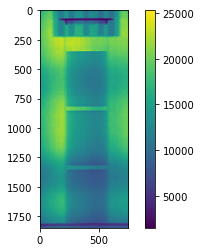

(1850, 750)

In [52]:
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
proj_crop_min.shape

Tilt correction ROI at 0 degree:


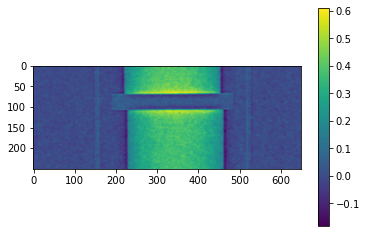

Tilt correction ROI at 180 degree:


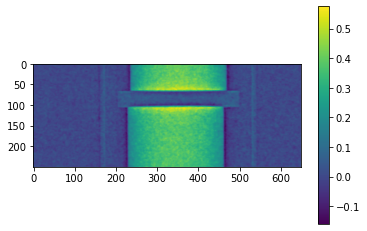

In [64]:
###################### need to change start
tt_xmin = 50
tt_xmax = 700
tt_ymin = 1250
tt_ymax = 1500
###################### need to change start
tt_roi = [tt_ymin, tt_xmin, tt_ymax, tt_xmax] # 
tt_0deg = proj_rmv[proj000_idx, tt_roi[0]:tt_roi[2], tt_roi[1]:tt_roi[3]]
tt_180deg = proj_rmv[proj180_idx, tt_roi[0]:tt_roi[2], tt_roi[1]:tt_roi[3]]
print("Tilt correction ROI at 0 degree:")
plt.imshow(tt_0deg)
plt.colorbar()
plt.show()
print("Tilt correction ROI at 180 degree:")
plt.imshow(tt_180deg)
plt.colorbar()
plt.show()

In [82]:
%%time
print("Finding the tilt angle...")
tilt_ang = tilt.calculate_tilt(image0=tt_0deg, image180=tt_180deg)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle...
Found the tilt angle:  0.3743322877602678
CPU times: user 40 s, sys: 1min 11s, total: 1min 51s
Wall time: 2.86 s


In [83]:
%%time
proj_to_recon = tilt.apply_tilt_correction(proj_rmv, tilt_ang.x, ncore=ncore)

Applying tilt corr:   0%|          | 0/783 [00:00<?, ?it/s]

CPU times: user 14.6 s, sys: 51.6 s, total: 1min 6s
Wall time: 1min 7s


Projection at 0 degree:


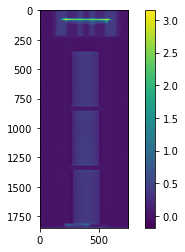

Projection at 180 degree (flipped):


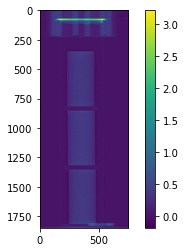

In [84]:
print("Projection at 0 degree:")
plt.imshow(proj_to_recon[proj000_idx])# vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Projection at 180 degree (flipped):")
plt.imshow(np.fliplr(proj_to_recon[proj180_idx]))# vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Find Center of Rotation

In [85]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_rmv[proj000_idx,:,:]), np.squeeze(proj_rmv[proj180_idx,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center) # 389.5

Estimated center of rotation: 389.25


# Reconstruction

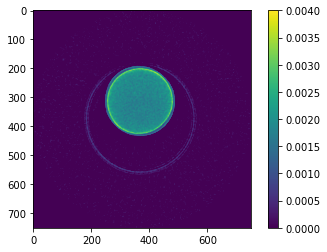

CPU times: user 1min 49s, sys: 18 s, total: 2min 7s
Wall time: 11.4 s


In [86]:
%%time
########## tomopy
recon = rocku.recon(proj_mlog_tilt, ang_rad, rot_center=rot_center, algorithm='gridrec')
# ########## svMBIR
# recon = recon(proj_tilt, theta, rot_center=rot_center, algorithm='svMBIR')
plt.imshow(recon[1200, :, :], vmax=0.004, vmin=0)
plt.colorbar()
plt.show()

In [25]:
pix_um = 42.7 #um
pix_cm = pix_um/10000
recon_cm = recon/pix_cm

# Export recon files

In [26]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name
dxchange.write_tiff_stack(recon_cm, fname=save_to + "/recon", overwrite=True, digit=4)